In [4]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from experiments.result_buckets import gpt3_curie, bilstm, roberta_specialized, roberta_unified, specialized_full_input_lexical

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
snli_results = {
    'specialized_full_input_lexical': specialized_full_input_lexical['snli-human'],
    'bilstm': bilstm['snli-human'],
    'specialized_roberta': roberta_specialized['snli-human'],
    'unified_roberta':  roberta_unified['snli-human'],
    'gpt3-curie': gpt3_curie['snli-human'],
    
}

test_results_snli = {
    'specialized_roberta': roberta_specialized['snli-test'],
    'unified_roberta':  roberta_unified['snli-test'],
    'specialized_full_input_lexical': specialized_full_input_lexical['snli-test'],
    'gpt3-curie': gpt3_curie['snli-test'],
    'bilstm': bilstm['snli-test'],
}
    

In [3]:
import seaborn as sns

In [ ]:
from simple_colors import *
import matplotlib.pyplot as plt
x = []
y = []
names = []

for model, analysis in snli_results.items():
    print(green(model))
    variance_law = analysis.law_of_total_variance_breakdown()
    test_set_accuracy = test_results_snli[model].accuracy

    print('Prop explained:', variance_law['prop_explained'])
    print('Total variance:', variance_law['total_var_y'])
    print('Test set accuracy:', test_set_accuracy)
    print('paraphrase acc:', analysis.paraphrase_accuracy())
    print('variance of bernoulli with acc:', (analysis.paraphrase_accuracy() * (1-analysis.paraphrase_accuracy())))

    print("\n#### Old Metrics ####")
    
    print('Unweighted consistency:', analysis.mean_unweighted_consistency)
    print('Weighted consistency:', analysis.calculate_weighted_consistency(test_results_snli[model]))
    
    print()
    x.append(test_set_accuracy)
    y.append(variance_law['prop_explained'])
    names.append(model)

sns.scatterplot(x=x, y=y)
for i in range(len(names)):
    plt.text(x[i], y[i], names[i], fontsize=10, ha='center', va='center', color='red')


<Axes: ylabel='Count'>

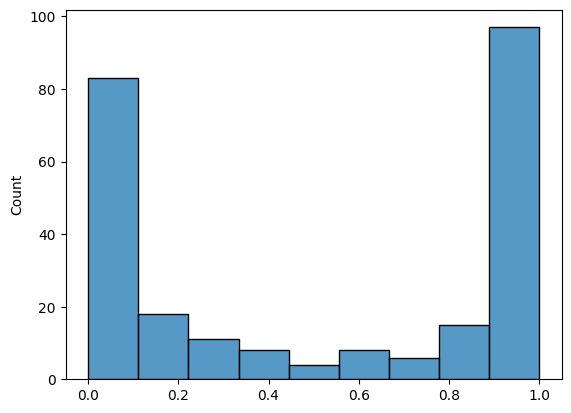

In [33]:
import plotly.express as px

x = [b.bucket_correctness_mean for b in snli_results['gpt3-curie'].buckets]
y = [b.bucket_correctness_variance for b in snli_results['gpt3-curie'].buckets]

sns.histplot(x)

# Set the x and y-axis limits
# fig.update_xaxes(range=[-0.1, 1.1])  # Set the x-axis limits
# fig.update_yaxes(range=[-1, 1])  # Set the y-axis limits

# Show the plot
#fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(x=[b.original_example_prediction.confidence_in_gold_label for b in snli_results['gpt3-curie'].buckets], 
                 y=[b.bucket_confidence_shift for b in snli_results['gpt3-curie'].buckets], 
                 labels={'x': 'original_confidence', 'y': 'confidence_shift'}
                )

# Set the x and y-axis limits
fig.update_xaxes(range=[-0.1, 1.1])  # Set the x-axis limits
fig.update_yaxes(range=[-1, 1])  # Set the y-axis limits

# Show the plot
fig.show()

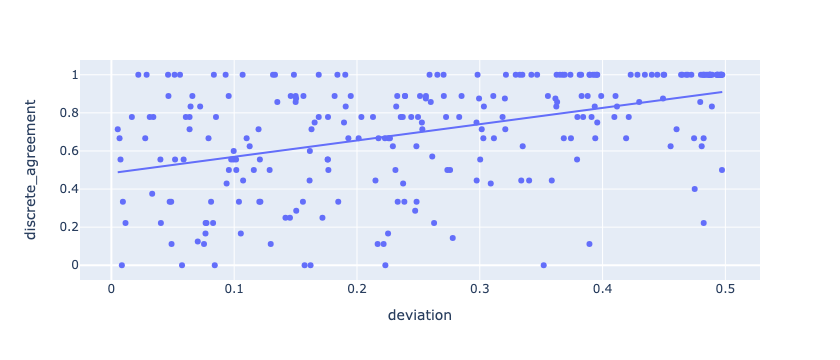

In [10]:
import plotly.express as px

fig = px.scatter(x=[b.original_example_prediction.confidence_deviation for b in snli_results['specialized_roberta'].buckets], 
                 y=[b.bucket_discrete_agreement for b in snli_results['specialized_roberta'].buckets], 
                 labels={'x': 'deviation', 'y': 'discrete_agreement'}, trendline="ols"
                )

# # Set the x and y-axis limits
# fig.update_xaxes(range=[-0.1, 1.1])  # Set the x-axis limits
# fig.update_yaxes(range=[-1, 1])  # Set the y-axis limits

# Show the plot
fig.show()

<Axes: ylabel='Count'>

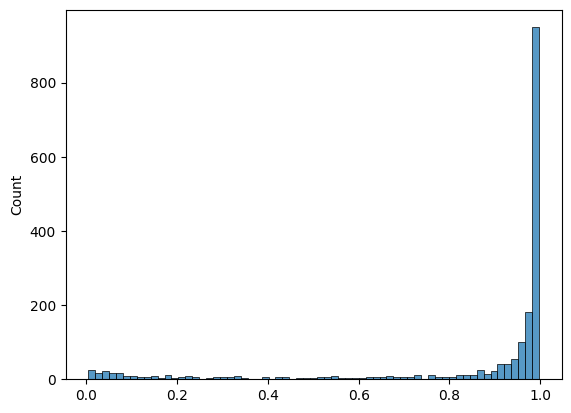

In [9]:
sns.histplot(test_results_snli['specialized_roberta'].confidences)

In [27]:
import numpy as np
hist, bin_edges = np.histogram(test_results_snli['specialized_roberta'].confidences, bins=10, density=False)

weights = hist / np.sum(hist)

In [30]:
selected_buckets = []

for i in range(len(bin_edges) - 1):
    edge_start = bin_edges[i] 
    edge_end = bin_edges[i + 1]
    weight = hist[i]/len(test_results_snli['specialized_roberta'].confidences
    

SyntaxError: unexpected EOF while parsing (495754951.py, line 7)

In [ ]:
## just do a bunch of different resampling (10K), and then in expectation, 
## the prop explained should be the same as doing the reweighting
# is reweighting = upsampling?